## Importing Libraries used

In [1]:
# !pip install -q torchmetrics

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets, models

from timeit import default_timer as timer
from tqdm.auto import tqdm
# from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
from collections import Counter


## Downloading Dataset from GitHub

In [2]:
data_path = Path('data')
image_path = data_path/'dataset'
zip_image_path = data_path/'dataset.zip'

if image_path.is_dir():
  print(f'{image_path} already exist... \nSkipping download')
else:
  print(f'{image_path} not found, creating {image_path}')
  image_path.mkdir(parents=True, exist_ok=True)

  with open(zip_image_path, 'wb') as f:
    request = requests.get('https://github.com/maheshkrishnam/SOI_SDS_2024/raw/main/train_data_with_classes.zip')
    print('Downloading dataset')
    f.write(request.content)

  with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)


data/dataset not found, creating data/dataset
Unzipping dataset


## Understanding and Visualizing the dataset

### Understating the structure of dataset

In [4]:
def walk_through_dir(image_path):
  for dirpath, dirnames, filenames in os.walk(image_path):
    if len(filenames) == 0:
      print(f'{dirpath} have directories {dirnames}')
    elif len(dirnames) == 0:
      print(f'{dirpath} having {len(filenames)} files')
    else :
      print(f'{dirpath} have directories {dirnames} having {len(filenames)} files')



In [5]:
# walk_through_dir(image_path=image_path)

data/dataset have directories ['dark dune', 'spider', 'swiss cheese', 'slope streak', 'other', 'crater', 'impact ejecta', 'bright dune']
data/dataset/dark dune having 216 files
data/dataset/spider having 66 files
data/dataset/swiss cheese having 223 files
data/dataset/slope streak having 335 files
data/dataset/other having 3651 files
data/dataset/crater having 1062 files
data/dataset/impact ejecta having 51 files
data/dataset/bright dune having 597 files


In [3]:
dataset_dir = image_path

dataset_dir

PosixPath('data/dataset')

### Visualizing images

#### Using PIL library

Image Class : other
Image shape : (227, 227) | Image width : 227 | Image height : 227
Image filename : /content/data/dataset/other/1956.jpg
Image : <PIL.JpegImagePlugin.JpegImageFile image mode=L size=227x227 at 0x7B16D9DAB7C0>


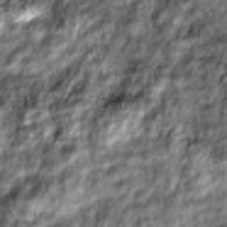

In [7]:
# RANDOM_SEED = 0
# random.seed(RANDOM_SEED)

# pattern = '*/*.jpg'
# image_path_list = list(image_path.glob(pattern))

# random_image_path = random.choice(image_path_list)

# image_class = random_image_path.parent.stem

# img = Image.open(random_image_path)
# print(f'Image Class : {image_class}')
# print(f'Image shape : {img.size} | Image width : {img.width} | Image height : {img.height}')
# print(f'Image filename : {img.filename}')
# print(f'Image : {img}')
# img


#### Using Matplot

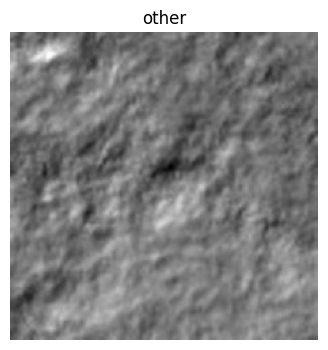

In [8]:
# # preprocessing requires PIL library
# plt.figure(figsize=(5,4))
# plt.imshow(img, cmap='gray')
# plt.title(image_class)
# plt.axis('off')
# plt.show()

## Loading dataset using ImageFolder

### Creating transforms

In [4]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### Converting Dataset using prebuild ImageFolder

In [5]:
whole_dataset = datasets.ImageFolder(
  root=dataset_dir,
  transform=transform,
  target_transform=None
)

whole_dataset

Dataset ImageFolder
    Number of datapoints: 6201
    Root location: data/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [11]:
whole_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6314, 0.6314, 0.6353],
          [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.6235, 0.6196],
          [0.0000, 0.0000, 0.0000,  ..., 0.6118, 0.6078, 0.6000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6431, 0.6353, 0.6314],
          [0.0000, 0.0000, 0.0000,  ..., 0.6118, 0.6039, 0.6000],
          [0.0000, 0.0000, 0.0000,  ..., 0.5961, 0.5882, 0.5804]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6314, 0.6314, 0.6353],
          [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.6235, 0.6196],
          [0.0000, 0.0000, 0.0000,  ..., 0.6118, 0.6078, 0.6000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6431, 0.6353, 0.6314],
          [0.0000, 0.0000, 0.0000,  ..., 0.6118, 0.6039, 0.6000],
          [0.0000, 0.0000, 0.0000,  ..., 0.5961, 0.5882, 0.5804]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6314, 0.6314, 0.6353],
          [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.6235, 0.6196],
          [0.0000, 0.0000, 0.0000,  ...,

### Storing classes with their index

In [6]:
class_name_idx = whole_dataset.class_to_idx
class_name = whole_dataset.classes

class_name_idx, class_name

({'bright dune': 0,
  'crater': 1,
  'dark dune': 2,
  'impact ejecta': 3,
  'other': 4,
  'slope streak': 5,
  'spider': 6,
  'swiss cheese': 7},
 ['bright dune',
  'crater',
  'dark dune',
  'impact ejecta',
  'other',
  'slope streak',
  'spider',
  'swiss cheese'])

### Train Validation Split

In [7]:
# train_dataset, val_dataset = train_test_split(whole_dataset, test_size=0.2, random_state=RANDOM_SEED)

# len(train_dataset), len(val_dataset)

train_dataset = whole_dataset

### Assigning Weight to each Class

In [8]:
all_labels = [label for _, label in whole_dataset]
class_counts = Counter(all_labels)

total_count = len(all_labels)
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
print(class_counts, class_weights)

sample_weights = [class_weights[label] for _, label in train_dataset]
# val_sample_weights = [class_weights[label] for _, label in val_dataset]

sample_weights = torch.tensor(sample_weights, dtype=torch.float)
# val_sample_weights = torch.tensor(val_sample_weights, dtype=torch.float)

# len(sample_weights), len(val_sample_weights), sample_weights, val_sample_weights
len(sample_weights), sample_weights

Counter({4: 3651, 1: 1062, 0: 597, 5: 335, 7: 223, 2: 216, 6: 66, 3: 51}) {0: 10.386934673366834, 1: 5.838983050847458, 2: 28.708333333333332, 3: 121.58823529411765, 4: 1.6984387838948234, 5: 18.51044776119403, 6: 93.95454545454545, 7: 27.807174887892376}


(6201, tensor([10.3869, 10.3869, 10.3869,  ..., 27.8072, 27.8072, 27.8072]))

#### Creating Sampler

In [9]:
sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# val_sampler = torch.utils.data.WeightedRandomSampler(
#     weights=val_sample_weights,
#     num_samples=len(val_sample_weights),
#     replacement=True
# )

# sampler, val_sampler
sampler

### Converting Dataset in DataLoader

In [10]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    sampler=sampler
)

# val_dataloader = DataLoader(
#     dataset=val_dataset,
#     batch_size=32,
#     num_workers=NUM_WORKERS,
#     sampler=val_sampler
# )


In [11]:
image, label = next(iter(train_dataloader))
image.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Model

### Device agnostic code

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Loading Pre-trained Model

In [13]:
# Load the pretrained ResNet50 model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = 8  # Change this to the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [20]:
# # For EfficientNet
# model = models.efficientnet_b0(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# # For DenseNet
# model = models.densenet121(pretrained=True)
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)


In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Setting up the loss function and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

### Training loop

In [16]:
num_epochs = 20  # Change this to the desired number of epochs

for epoch in tqdm(range(num_epochs)):
    print(f'EPOCH : {epoch+1} \n-----------')
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

    print(f'Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')


    # model.eval()
    # with torch.no_grad():
    #     running_corrects = 0

    #     for inputs, labels in val_dataloader:
    #         inputs, labels = inputs.to(device), labels.to(device)

    #         outputs = model(inputs)
    #         _, preds = torch.max(outputs, 1)

    #         running_corrects += torch.sum(preds == labels.data)

    #     val_acc = running_corrects.double() / len(val_dataloader.dataset)

    #     print(f'Validation Accuracy: {val_acc:.4f}')


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 1 
-----------
Loss: 0.5319 | Accuracy: 0.8302
EPOCH : 2 
-----------
Loss: 0.2555 | Accuracy: 0.9142
EPOCH : 3 
-----------
Loss: 0.1577 | Accuracy: 0.9455
EPOCH : 4 
-----------
Loss: 0.1492 | Accuracy: 0.9505
EPOCH : 5 
-----------
Loss: 0.1381 | Accuracy: 0.9582
EPOCH : 6 
-----------
Loss: 0.1106 | Accuracy: 0.9658
EPOCH : 7 
-----------
Loss: 0.0941 | Accuracy: 0.9703
EPOCH : 8 
-----------
Loss: 0.0835 | Accuracy: 0.9739
EPOCH : 9 
-----------
Loss: 0.0638 | Accuracy: 0.9789
EPOCH : 10 
-----------
Loss: 0.0678 | Accuracy: 0.9782
EPOCH : 11 
-----------
Loss: 0.1092 | Accuracy: 0.9671
EPOCH : 13 
-----------
Loss: 0.0646 | Accuracy: 0.9806
EPOCH : 14 
-----------
Loss: 0.0486 | Accuracy: 0.9860
EPOCH : 15 
-----------
Loss: 0.0339 | Accuracy: 0.9873
EPOCH : 16 
-----------
Loss: 0.0624 | Accuracy: 0.9815
EPOCH : 17 
-----------
Loss: 0.0505 | Accuracy: 0.9827
EPOCH : 18 
-----------
Loss: 0.0638 | Accuracy: 0.9824
EPOCH : 19 
-----------
Loss: 0.0274 | Accuracy: 0.9905
E

In [17]:
data_path = Path('data')
image_path = data_path / 'test_images'
zip_image_path = data_path / 'test_images.zip'

if not image_path.is_dir():
  image_path.mkdir(parents=True, exist_ok=True)
  with open(zip_image_path, 'wb') as f:
    request = requests.get('https://github.com/maheshkrishnam/SOI_SDS_2024/raw/main/test_dataset.zip')
    print('Downloading space_images.zip...')
    f.write(request.content)

  with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
    print('Unzipping space_images.zip...')
    zip_ref.extractall(image_path)
    print('Unzipping done...')
  os.remove(zip_image_path)
else:
  print(f'{image_path} already exists')


Unzipping space_images.zip...
Unzipping done...


In [18]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]


In [19]:
transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

In [20]:
image_path = '/content/data/test_images/test_dataset'

In [21]:
test_dataset = TestDataset(root_dir=image_path, transform=transform)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [22]:
image, image_name = next(iter(test_dataloader))

Text(0.5, 1.0, '173.jpg')

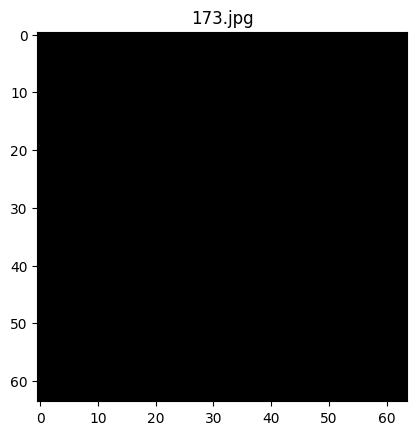

In [23]:
plt.imshow(image[3].permute(1,2,0), cmap='gray')
plt.title(image_name[3])

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
file_names = []

with torch.no_grad():
    for images, image_names in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        file_names.extend(image_names)

# Create a DataFrame and save to CSV
df = pd.DataFrame({'file_name': file_names, 'prediction': predictions})
df.to_csv('resnet18_complete.csv', index=False)


In [ ]:
data_path = Path('data')
image_path = data_path / 'test_images'
zip_image_path = data_path / 'test_images.zip'

if not image_path.is_dir():
  image_path.mkdir(parents=True, exist_ok=True)
  with open(zip_image_path, 'wb') as f:
    request = requests.get('https://github.com/maheshkrishnam/SOI_SDS_2024/raw/main/test_dataset.zip')
    print('Downloading space_images.zip...')
    f.write(request.content)

  with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
    print('Unzipping space_images.zip...')
    zip_ref.extractall(image_path)
    print('Unzipping done...')
  os.remove(zip_image_path)
else:
  print(f'{image_path} already exists')


class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]


transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

image_path = '/content/data/test_images/test_dataset'

test_dataset = TestDataset(root_dir=image_path, transform=transform)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
file_names = []

with torch.no_grad():
    for images, image_names in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        file_names.extend(image_names)

# Create a DataFrame and save to CSV
df = pd.DataFrame({'file_name': file_names, 'prediction': predictions})
df.to_csv('efficientnet_b0.csv', index=False)


In [25]:
# # For EfficientNet
# model2 = models.efficientnet_b0(pretrained=True)
# model2.classifier[1] = nn.Linear(model2.classifier[1].in_features, num_classes)

# For DenseNet
model2 = models.densenet121(pretrained=True)
model2.classifier = nn.Linear(model2.classifier.in_features, num_classes)

model2 = model2.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 134MB/s]


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)


In [28]:
num_epochs = 20  # Change this to the desired number of epochs

for epoch in tqdm(range(num_epochs)):
    print(f'EPOCH : {epoch+1} \n-----------')
    model2.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model2(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

    print(f'Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')


    # model2.eval()
    # with torch.no_grad():
    #     running_corrects = 0

    #     for inputs, labels in val_dataloader:
    #         inputs, labels = inputs.to(device), labels.to(device)

    #         outputs = model2(inputs)
    #         _, preds = torch.max(outputs, 1)

    #         running_corrects += torch.sum(preds == labels.data)

    #     val_acc = running_corrects.double() / len(val_dataloader.dataset)

    #     print(f'Validation Accuracy: {val_acc:.4f}')


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 1 
-----------
Loss: 0.2620 | Accuracy: 0.9121
EPOCH : 2 
-----------
Loss: 0.1799 | Accuracy: 0.9371
EPOCH : 3 
-----------
Loss: 0.1508 | Accuracy: 0.9519
EPOCH : 4 
-----------
Loss: 0.1083 | Accuracy: 0.9629
EPOCH : 5 
-----------
Loss: 0.1371 | Accuracy: 0.9521
EPOCH : 6 
-----------
Loss: 0.0884 | Accuracy: 0.9705
EPOCH : 7 
-----------
Loss: 0.1085 | Accuracy: 0.9648
EPOCH : 8 
-----------
Loss: 0.0890 | Accuracy: 0.9694
EPOCH : 9 
-----------
Loss: 0.1438 | Accuracy: 0.9536
EPOCH : 10 
-----------
Loss: 0.0838 | Accuracy: 0.9737
EPOCH : 11 
-----------
Loss: 0.0545 | Accuracy: 0.9821
EPOCH : 12 
-----------
Loss: 0.0458 | Accuracy: 0.9858
EPOCH : 13 
-----------
Loss: 0.0640 | Accuracy: 0.9790
EPOCH : 14 
-----------
Loss: 0.0996 | Accuracy: 0.9710
EPOCH : 15 
-----------
Loss: 0.0703 | Accuracy: 0.9776
EPOCH : 16 
-----------
Loss: 0.0528 | Accuracy: 0.9818
EPOCH : 17 
-----------
Loss: 0.0545 | Accuracy: 0.9829
EPOCH : 18 
-----------
Loss: 0.0480 | Accuracy: 0.9840
E

In [29]:
def fn(model):
  data_path = Path('data')
  image_path = data_path / 'test_images'
  zip_image_path = data_path / 'test_images.zip'

  if not image_path.is_dir():
    image_path.mkdir(parents=True, exist_ok=True)
    with open(zip_image_path, 'wb') as f:
      request = requests.get('https://github.com/maheshkrishnam/SOI_SDS_2024/raw/main/test_dataset.zip')
      print('Downloading space_images.zip...')
      f.write(request.content)

    with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
      print('Unzipping space_images.zip...')
      zip_ref.extractall(image_path)
      print('Unzipping done...')
    os.remove(zip_image_path)
  else:
    print(f'{image_path} already exists')


  class TestDataset(Dataset):
      def __init__(self, root_dir, transform=None):
          self.root_dir = root_dir
          self.transform = transform
          self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

      def __len__(self):
          return len(self.image_files)

      def __getitem__(self, idx):
          img_name = os.path.join(self.root_dir, self.image_files[idx])
          image = Image.open(img_name).convert('RGB')
          if self.transform:
              image = self.transform(image)
          return image, self.image_files[idx]


  transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ])

  image_path = '/content/data/test_images/test_dataset'

  test_dataset = TestDataset(root_dir=image_path, transform=transform)
  test_dataloader = DataLoader(
      test_dataset,
      batch_size=BATCH_SIZE,
      shuffle=False
  )

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  predictions = []
  file_names = []

  with torch.no_grad():
      for images, image_names in test_dataloader:
          images = images.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          predictions.extend(predicted.cpu().numpy())
          file_names.extend(image_names)

  # Create a DataFrame and save to CSV
  df = pd.DataFrame({'file_name': file_names, 'prediction': predictions})
  df.to_csv('densenet121_complete.csv', index=False)


In [30]:
fn(model2)

data/test_images already exists


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
model.eval()
with torch.inference_mode():
  for inputs, labels in val_dataloader:
          output = model(inputs.to(device)) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

# constant for classes
classes = class_name

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)